In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus as pp
import seaborn as sns

from IPython.display import display
from IPython.display import Image

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor

In [2]:
class CONFIG:
    INDEXS = ["R2 Pred", "R2", "EV", "ME", "MEAN_AE", "MSE", "MEDIAN_AE", "HIT@10", "HIT@100"]

# Load Dataset

In [3]:
header = pd.read_csv("Dataset/header.csv", header=None)
header

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable


In [4]:
training_dataset = pd.read_csv("Dataset/Training/Features_Variant_5.csv",
                               header=None,
                               names=[header.iat[0, i] for i in range(0, 54)])
training_dataset.sample(n=10)

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
146475,1959278,0,12641,18,0.0,540.0,22.968182,12.0,46.110755,0.0,...,0,0,1,0,0,0,0,0,0,13
194123,2156275,114,47233,9,0.0,420.0,79.693092,62.0,72.896208,0.0,...,1,0,1,0,0,0,0,0,0,0
82385,52719,19238,715,6,0.0,5.0,0.231405,0.0,0.840703,0.0,...,0,0,0,0,0,1,0,0,0,0
170648,19320,0,15,36,0.0,15.0,3.429668,2.0,3.826752,0.0,...,0,0,0,1,0,0,0,0,0,8
183051,608825,150,11239,44,0.0,164.0,36.774411,31.0,24.120900,0.0,...,0,0,0,0,0,0,0,1,0,22
120890,1045111,0,34768,16,0.0,1048.0,25.393939,3.0,111.776637,0.0,...,0,0,0,1,0,0,0,0,0,1
165138,149139,0,145,14,0.0,122.0,2.428884,1.0,10.682604,0.0,...,1,0,0,0,0,0,0,0,1,0
57694,692498,0,218565,25,0.0,1115.0,316.750000,190.5,367.536648,0.0,...,0,0,0,0,0,0,0,1,0,3
191631,3337470,27805,11736,40,0.0,230.0,9.834388,3.0,23.592018,0.0,...,0,0,0,0,0,1,0,0,0,0
122457,367390,0,2678,100,0.0,112.0,12.034813,7.0,15.276295,0.0,...,0,0,0,0,0,0,0,1,0,0


# Data Preprocessing

In [5]:
post_published_weekday = (training_dataset["Post published weekday-Monday"]
                          + training_dataset["Post published weekday-Tuesday"]
                          + training_dataset["Post published weekday-Wednesday"]
                          + training_dataset["Post published weekday-Thursday"]
                          + training_dataset["Post published weekday-Friday"]).astype("int")
post_published_weekend = (training_dataset["Post published weekday-Sunday"]
                          + training_dataset["Post published weekday-Saturday"]).astype("int")
training_dataset.insert(46, "Post published weekday", post_published_weekday)
training_dataset.insert(47, "Post published weekend", post_published_weekend)
training_dataset.drop(
    ["Post published weekday-Saturday",
     "Post published weekday-Sunday",
     "Post published weekday-Monday",
     "Post published weekday-Tuesday",
     "Post published weekday-Wednesday",
     "Post published weekday-Thursday",
     "Post published weekday-Friday"], axis = 1, inplace = True)
training_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday,Post published weekend,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,1,0,0,0,0,0,0,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,0,0,1,0
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,1,0,0,0,0,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,203
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,42
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,51
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,0,1,0,0,17


In [6]:
# base_datetime_weekday = (training_dataset["Base DateTime weekday-Monday"]
#                           + training_dataset["Base DateTime weekday-Tuesday"]
#                           + training_dataset["Base DateTime weekday-Wednesday"]
#                           + training_dataset["Base DateTime weekday-Thursday"]
#                           + training_dataset["Base DateTime weekday-Friday"]).astype("int")
# base_datetime_weekend = (training_dataset["Base DateTime weekday-Sunday"]
#                           + training_dataset["Base DateTime weekday-Saturday"]).astype("int")
# training_dataset.insert(48, "Base DateTime weekday", base_datetime_weekday)
# training_dataset.insert(49, "Base DateTime weekend", base_datetime_weekend)
# training_dataset.drop(
#     ["Base DateTime weekday-Saturday",
#      "Base DateTime weekday-Sunday",
#      "Base DateTime weekday-Monday",
#      "Base DateTime weekday-Tuesday",
#      "Base DateTime weekday-Wednesday",
#      "Base DateTime weekday-Thursday",
#      "Base DateTime weekday-Friday"], axis = 1, inplace = True)
# training_dataset

In [7]:
features = training_dataset.iloc[:, :48]
features

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,H Local,Post published weekday,Post published weekend,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,24,1,0,0,0,0,0,1,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,24,1,0,1,0,0,0,0,0,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,24,1,0,0,0,0,0,0,0,1
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,24,1,0,0,1,0,0,0,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,24,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,24,1,0,0,0,0,1,0,0,0
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,24,1,0,0,0,0,1,0,0,0
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,24,1,0,0,0,0,1,0,0,0
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,24,1,0,0,0,0,0,1,0,0


In [8]:
labels = training_dataset.iloc[:, -1:]
labels

,Target Variable
0,0
1,0
2,0
3,0
4,0
...,...
199025,203
199026,42
199027,51
199028,17


In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.3, random_state=42)

# Voting Regressor

## Model Training

In [10]:
def train_model(model):
    model.fit(X_train, y_train.values.ravel())
    predict = model.predict(X_test)
    return predict

In [11]:
def plot_test_predict(y_train, y_test, predict, axes=None, k=None):
    test_predict = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(predict.transpose())], axis=1)
    headers = ["Test", "Predict"]
    test_predict.columns = headers
    if axes is not None and k is not None:
        sns.lineplot(data=test_predict.sample(n=200), ax=axes[k]).set_title("Test Predict Curve k = " + str(k))
    else:
        sns.lineplot(data=test_predict.sample(n=200)).set_title("Test Predict Curve")
    plt.show()
    sns.residplot(x=predict, y=y_test.to_numpy(), lowess=True).set_title("Residuals")
    plt.show()
    y_test_np = y_test.to_numpy().flatten()
    sns.residplot(x=predict, y=y_test_np * (predict - y_test_np), lowess=True).set_title("Residuals")
    plt.show()

## Model Evaluation

In [12]:
def evaluate(model, X_test, y_test, predict):

    # R-Squared Prediction
    r2_pred = model.score(X_test, y_test)
    
    # R-Squared
    r2 = r2_score(y_test, predict)
    
    # Explained Variance Score
    ev = explained_variance_score(y_test, predict)
    
    # Max Error
    me = max_error(y_test, predict)
    
    # Mean Absolute Error
    mean_ae = mean_absolute_error(y_test, predict)
    
    # Mean Squared Error
    mse = mean_squared_error(y_test, predict)
    
    # Median Absolute Error
    median_ae = median_absolute_error(y_test, predict)
    
    # Hit@10
    y_test_np = y_test.to_numpy().flatten()
    hit = np.abs(y_test_np - predict) < 10
    hit_10 = np.sum(hit) / hit.shape[0]
    
    # Hit@100
    y_test_np = y_test.to_numpy().flatten()
    ordered_y_test = np.argsort(y_test_np)
    max_y_test = ordered_y_test[-100:]
    ordered_predict = np.argsort(predict)
    max_predict = ordered_predict[-100:]
    acc = 0
    for pred in max_predict:
        if pred in max_y_test:
            acc += 1
    hit_100 = acc / 100
    
    return r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100

## Final Model

In [13]:
def train_final_model(max_depth=None, min_samples_split=2, learning_rate=0.5, n_estimators=100):
    # LGBMRegressor
    lgbmr_model = LGBMRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # HistGradientBoostingRegressor
    hgbr_model = HistGradientBoostingRegressor(
        max_depth=max_depth,
        random_state=42,
    )
    
    # RandomForestRegressor
    rfr_model = RandomForestRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # BaggingRegressor
    br_model = BaggingRegressor(
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # XGBRegressor
    xgbr_model = XGBRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # GradientBoostingRegressor
    gbr_model = GradientBoostingRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # ExtraTreesRegressor
    etr_model = ExtraTreesRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # CatBoostRegressor
    cbr_model = CatBoostRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        random_state=42,
    )
    
    # VotingRegressor
    model = VotingRegressor(estimators=[('lgbmr', lgbmr_model),
                                        ('hgbr', hgbr_model),
                                        ('rfr', rfr_model),
                                        ('br', br_model),
                                        ('xgbr', xgbr_model),
                                        ('gbr', gbr_model),
                                        ('etr', etr_model),
                                        ('cbr', cbr_model)])

    # Model Training
    predict = train_model(model)
    plot_test_predict(y_train, y_test, predict)

    # Model Evaluation
    r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100 = evaluate(model, X_test, y_test, predict)

    results = pd.DataFrame({
        "Index": CONFIG.INDEXS, 
        "Mean": [r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100]
    })
    print(results)

0:	learn: 33.4023853	total: 259ms	remaining: 2m 9s
1:	learn: 31.7282411	total: 441ms	remaining: 1m 49s
2:	learn: 30.2286754	total: 632ms	remaining: 1m 44s
3:	learn: 28.9460989	total: 822ms	remaining: 1m 41s
4:	learn: 27.6947959	total: 1.02s	remaining: 1m 41s
5:	learn: 26.6657917	total: 1.22s	remaining: 1m 40s
6:	learn: 25.6345631	total: 1.41s	remaining: 1m 39s
7:	learn: 24.7878252	total: 1.59s	remaining: 1m 38s
8:	learn: 24.0130660	total: 1.78s	remaining: 1m 37s
9:	learn: 23.3135457	total: 1.98s	remaining: 1m 36s
10:	learn: 22.6857655	total: 2.17s	remaining: 1m 36s
11:	learn: 22.1123776	total: 2.37s	remaining: 1m 36s
12:	learn: 21.5922588	total: 2.57s	remaining: 1m 36s
13:	learn: 21.0858948	total: 2.75s	remaining: 1m 35s
14:	learn: 20.6578295	total: 2.94s	remaining: 1m 34s
15:	learn: 20.2446993	total: 3.12s	remaining: 1m 34s
16:	learn: 19.8622878	total: 3.32s	remaining: 1m 34s
17:	learn: 19.4917450	total: 3.51s	remaining: 1m 33s
18:	learn: 19.1783337	total: 3.7s	remaining: 1m 33s
19:	l

156:	learn: 9.3022238	total: 30s	remaining: 1m 5s
157:	learn: 9.2763348	total: 30.2s	remaining: 1m 5s
158:	learn: 9.2472369	total: 30.4s	remaining: 1m 5s
159:	learn: 9.2291741	total: 30.6s	remaining: 1m 5s
160:	learn: 9.1973105	total: 30.8s	remaining: 1m 4s
161:	learn: 9.1792926	total: 31s	remaining: 1m 4s
162:	learn: 9.1574766	total: 31.2s	remaining: 1m 4s
163:	learn: 9.1246800	total: 31.4s	remaining: 1m 4s
164:	learn: 9.0980746	total: 31.6s	remaining: 1m 4s
165:	learn: 9.0741464	total: 31.8s	remaining: 1m 3s
166:	learn: 9.0475053	total: 32s	remaining: 1m 3s
167:	learn: 9.0239795	total: 32.2s	remaining: 1m 3s
168:	learn: 8.9848802	total: 32.4s	remaining: 1m 3s
169:	learn: 8.9602922	total: 32.6s	remaining: 1m 3s
170:	learn: 8.9388958	total: 32.7s	remaining: 1m 2s
171:	learn: 8.9144384	total: 32.9s	remaining: 1m 2s
172:	learn: 8.8902684	total: 33.1s	remaining: 1m 2s
173:	learn: 8.8444715	total: 33.3s	remaining: 1m 2s
174:	learn: 8.8267558	total: 33.5s	remaining: 1m 2s
175:	learn: 8.7888

316:	learn: 6.2882725	total: 1m	remaining: 34.9s
317:	learn: 6.2799279	total: 1m	remaining: 34.7s
318:	learn: 6.2739501	total: 1m	remaining: 34.5s
319:	learn: 6.2603411	total: 1m 1s	remaining: 34.3s
320:	learn: 6.2537390	total: 1m 1s	remaining: 34.1s
321:	learn: 6.2475455	total: 1m 1s	remaining: 33.9s
322:	learn: 6.2397411	total: 1m 1s	remaining: 33.8s
323:	learn: 6.2336586	total: 1m 1s	remaining: 33.6s
324:	learn: 6.2193667	total: 1m 1s	remaining: 33.4s
325:	learn: 6.2080129	total: 1m 2s	remaining: 33.2s
326:	learn: 6.1915075	total: 1m 2s	remaining: 33s
327:	learn: 6.1748497	total: 1m 2s	remaining: 32.8s
328:	learn: 6.1628848	total: 1m 2s	remaining: 32.6s
329:	learn: 6.1512482	total: 1m 2s	remaining: 32.4s
330:	learn: 6.1444018	total: 1m 3s	remaining: 32.2s
331:	learn: 6.1364106	total: 1m 3s	remaining: 32.1s
332:	learn: 6.1271738	total: 1m 3s	remaining: 31.9s
333:	learn: 6.1229032	total: 1m 3s	remaining: 31.7s
334:	learn: 6.1116912	total: 1m 3s	remaining: 31.5s
335:	learn: 6.1070667	t

474:	learn: 4.9200588	total: 1m 30s	remaining: 4.76s
475:	learn: 4.9133256	total: 1m 30s	remaining: 4.57s
476:	learn: 4.9098127	total: 1m 30s	remaining: 4.38s
477:	learn: 4.8997366	total: 1m 31s	remaining: 4.19s
478:	learn: 4.8948701	total: 1m 31s	remaining: 4s
479:	learn: 4.8869862	total: 1m 31s	remaining: 3.81s
480:	learn: 4.8818323	total: 1m 31s	remaining: 3.62s
481:	learn: 4.8748427	total: 1m 31s	remaining: 3.43s
482:	learn: 4.8682851	total: 1m 31s	remaining: 3.24s
483:	learn: 4.8600682	total: 1m 32s	remaining: 3.05s
484:	learn: 4.8552708	total: 1m 32s	remaining: 2.85s
485:	learn: 4.8488300	total: 1m 32s	remaining: 2.67s
486:	learn: 4.8397540	total: 1m 32s	remaining: 2.48s
487:	learn: 4.8361270	total: 1m 32s	remaining: 2.28s
488:	learn: 4.8308869	total: 1m 33s	remaining: 2.09s
489:	learn: 4.8194609	total: 1m 33s	remaining: 1.9s
490:	learn: 4.8131103	total: 1m 33s	remaining: 1.71s
491:	learn: 4.8070766	total: 1m 33s	remaining: 1.52s
492:	learn: 4.8044515	total: 1m 33s	remaining: 1.3

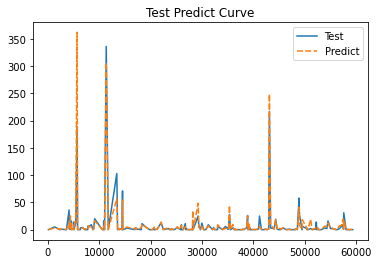

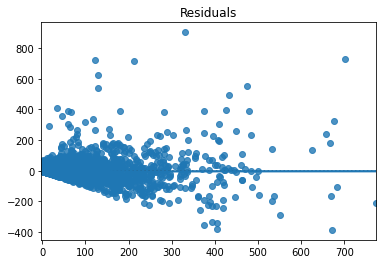

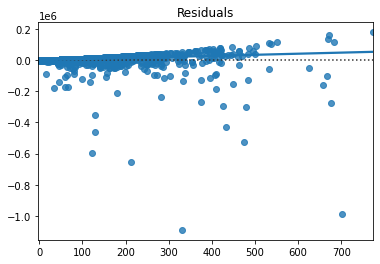

       Index        Mean
0    R2 Pred    0.758158
1         R2    0.758158
2         EV    0.758178
3         ME  903.926816
4    MEAN_AE    3.213069
5        MSE  248.158996
6  MEDIAN_AE    0.468998
7     HIT@10    0.941550
8    HIT@100    0.620000


In [14]:
train_final_model(max_depth=12, min_samples_split=0.0001, learning_rate=0.1, n_estimators=500)